In [0]:
!pip install matplotlib==3.1.0

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

In [0]:
def iris_data_preprocessing():
  # Preprocess the IRIS dataset
  IRIS_Train = "http://download.tensorflow.org/data/iris_training.csv"
  IRIS_Test = "http://download.tensorflow.org/data/iris_test.csv"

  data_labels = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species']
  train_dataset = pd.read_csv(IRIS_Train, names=data_labels, skiprows=1)
  test_dataset = pd.read_csv(IRIS_Test, names=data_labels, skiprows=1)

  # Separate the X, y labels
  y_train = pd.get_dummies(train_dataset.species)
  X_train = train_dataset.drop('species', axis=1)

  y_test = pd.get_dummies(test_dataset.species)
  X_test = test_dataset.drop('species', axis=1)

  print("Size of train set: ", X_train.shape)
  print("Size of test set: ", X_test.shape)

  return (X_train, y_train), (X_test, y_test)

In [0]:
train, test = iris_data_preprocessing()

Size of train set:  (120, 4)
Size of test set:  (30, 4)


In [0]:
type(train[0])
train[0].iloc[0,:]

sepal-length    6.4
sepal-width     2.8
petal-length    5.6
petal-width     2.2
Name: 0, dtype: float64

In [0]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

tf.reset_default_graph()


In [0]:
from tensorboard.plugins.hparams import api as hp

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear logs from previous runs 
!rm -rf ./tf_logs/

from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import KFold

In [0]:
class FeedForwardKerasModel:
    
    def __init__(self):

        tf.reset_default_graph()

        # For Hyperparameter reference: https://github.com/tensorflow/tensorboard/blob/master/tensorboard/plugins/hparams/hparams_demo.py
        self.learning_rate = hp.HParam('learning_rate', hp.RealInterval(0.1, 0.8))
        self.optimizer = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
        self.num_units_l1 = hp.HParam('num_units_l1', hp.Discrete([10, 20, 30]))
        self.num_units_l2 = hp.HParam('num_units_l2', hp.Discrete([10, 20, 30]))

        self.hparams = {self.learning_rate: self.learning_rate, self.optimizer: self.optimizer, self.num_units_l1: self.num_units_l1, self.num_units_l2: self.num_units_l2}

        METRIC_ACCURACY = 'accuracy'
        
        # To store event details
        with tf.summary.FileWriter('tf_logs/hparam_tuning'):
          hp.hparams_config(
              hparams=[self.learning_rate, self.optimizer, self.num_units_l1, self.num_units_l2], 
              metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
          )
        
        self.model = None
        return
    
    def train_model(self, hparams, train_data, cross_validation_data):
      
      X_train, y_train = train_data[0], train_data[1]
      X_cv, y_cv = cross_validation_data[0], cross_validation_data[1]

      self.model = tf.keras.models.Sequential([tf.keras.layers.Dense(hparams[self.num_units_l1], activation=tf.nn.relu, input_shape=(4,)),
                                                 tf.keras.layers.Dense(hparams[self.num_units_l2], activation=tf.nn.relu),
                                                 tf.keras.layers.Dense(3)])
      
      self.model.compile(optimizer=hparams[self.optimizer], loss='categorical_crossentropy', metrics=['accuracy'])
      
      self.model.fit(X_train, y_train, epochs=1000)
      
      _, accuracy = self.model.evaluate(X_cv, y_cv)

      return accuracy

    def run(self, run_dir, hparams, train):
      
      with tf.summary.FileWriter(run_dir):
        # record the values used in this trial
        hp.hparams(hparams)
        
        accuracy = []

        # KFold spliting
        kf = KFold(n_splits=2)
        for train_index, test_index in kf.split(train[0]):
          xtrain = cvx = ytrain = cvy = []

          xtrain = train[0].loc[train_index]
          ytrain = train[1].loc[train_index]
          cvx = train[0].loc[test_index]
          cvy = train[1].loc[test_index]

          accuracy.append(self.train_model(hparams, [xtrain, ytrain], [cvx, cvy]))
        
        tf.summary.scalar('accuracy', np.mean(accuracy), step=1)
        
      return
    
    def grid_search(self, train, test):

      session_index = 0

      for units_l1 in self.num_units_l1.domain.values:
        for units_l2 in self.num_units_l2.domain.values:
          for lr in (self.learning_rate.domain.min_value, self.learning_rate.domain.max_value):
            for opt in self.optimizer.domain.values:
              hparams = {self.num_units_l1: units_l1, self.num_units_l2: units_l2, self.learning_rate: lr, self.optimizer: opt}
              run_name = "run-%d" % session_index
              print('--- Starting trial: %s' % run_name)
              print({h.name: hparams[h] for h in hparams})
              self.run('tf_logs/hparam_tuning/' + run_name, hparams, train)
              session_index += 1
      return
  
    def random_search(self, train, test):
      return 


In [0]:
m = FeedForwardKerasModel()
m.grid_search(train, test)


--- Starting trial: run-0
{'num_units_l1': 10, 'num_units_l2': 10, 'learning_rate': 0.1, 'optimizer': 'adam'}
Train on 80 samples
Epoch 1/1000
80/80 [==============================] - 0s 663us/sample - loss: 6.0524 - acc: 0.3125
Epoch 2/1000
80/80 [==============================] - 0s 110us/sample - loss: 6.0449 - acc: 0.3125
Epoch 3/1000
80/80 [==============================] - 0s 129us/sample - loss: 6.0443 - acc: 0.3125
Epoch 4/1000
80/80 [==============================] - 0s 116us/sample - loss: 6.0443 - acc: 0.3125
Epoch 5/1000
80/80 [==============================] - 0s 108us/sample - loss: 6.0443 - acc: 0.3125
Epoch 6/1000
80/80 [==============================] - 0s 106us/sample - loss: 6.0443 - acc: 0.3125
Epoch 7/1000
80/80 [==============================] - 0s 105us/sample - loss: 6.0443 - acc: 0.3125
Epoch 8/1000
80/80 [==============================] - 0s 99us/sample - loss: 6.0443 - acc: 0.3125
Epoch 9/1000
80/80 [==============================] - 0s 127us/sample - loss: 6

In [0]:
class FeedForwardModel:

  def __init__(self, learning_rate=0.005, num_iters=500, batch_size=120):
    self.learning_rate = learning_rate
    self.num_iters = num_iters
    self.batch_size = batch_size

    self.model = None

    self.initialize_layers()
    self.file_writer = None
    return
  
  def initialize_layers(self):
    # TODO: Generalize this.

    features = 4
    neurons_h1 = 30   # Neurons in 1st hidden layer
    neurons_h2 = 10   # Neurons in 2nd hidden layer
    out_classes = 3

    self.weights = {
        "h1": tf.Variable(tf.random_normal([features, neurons_h1])),
        "h2": tf.Variable(tf.random_normal([neurons_h1, neurons_h2])),
        "out": tf.Variable(tf.random_normal([neurons_h2, out_classes]))
    }

    self.biases = {
        "b1": tf.Variable(tf.random_normal([neurons_h1])),
        "b2": tf.Variable(tf.random_normal([neurons_h2])),
        "out": tf.Variable(tf.random_normal([out_classes])),
    }
    
    self.X = tf.placeholder("float", [None, features])
    self.Y = tf.placeholder("float", [None, out_classes])
    return
  
  def create_model(self, x):
    # Todo: Generalize model skeleton construction
    hidden_layer_1 = tf.add(tf.matmul(x, self.weights["h1"]), self.biases["b1"])
    hidden_layer_2 = tf.add(tf.matmul(hidden_layer_1, self.weights["h2"]), self.biases["b2"])
    output_layer = tf.matmul(hidden_layer_2, self.weights["out"]) + self.biases["out"]
    self.model = output_layer
    return
  
  def plot_confusion_matrix(self, y_, y_predicted):
    cm = confusion_matrix(y_, y_predicted)
    plt.figure(figsize = (10,7))
    sn.heatmap(cm, annot=True, cmap="YlGnBu")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    return

  def train_and_test(self, train_data, test_data):

    X_train = train_data[0]
    y_train = train_data[1]

    X_test = test_data[0]
    y_test = test_data[1]
    

    # Loss function. Todo: Generalize this.
    # More about softmax_cross_entropy_with_logits and its gradient calculation: https://stackoverflow.com/a/39499486
    loss_opn = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.model, labels=self.Y))
    
    # To minimize the loss
    self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learning_rate)
    train_proc = self.optimizer.minimize(loss_opn)
    
    # Eval
    predict = tf.nn.softmax(self.model)
    c_p = tf.equal(tf.argmax(predict, 1), tf.argmax(self.Y, 1))
    accuracy = tf.reduce_mean(tf.cast(c_p, tf.float32))
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    loss_summary = tf.summary.scalar("Loss", loss_opn)
    fw = tf.summary.FileWriter(logdir, tf.get_default_graph())

    for i in range(self.num_iters):
      sess.run(train_proc, feed_dict={self.X: X_train, self.Y: y_train})
      summary_str = loss_summary.eval(session=sess, feed_dict={self.X: X_train, self.Y: y_train})
      fw.add_summary(summary_str, i)
      if i % 500 == 0:
        loss, acc = sess.run([loss_opn, accuracy], feed_dict={self.X: X_train, self.Y: y_train})
        print("Iter " + str(i) + " Loss: " + str(loss) + " and Train accuracy: " + str(acc))
    
    
    
        
    print("On Test Set:")
    print("Accuracy: ", sess.run(accuracy, feed_dict={self.X: X_test, self.Y: y_test}))

    # prediction = tf.nn.softmax(self.model)
    predicted_labels = sess.run(predict, feed_dict={self.X: X_test})
    y_ = tf.argmax(y_test, 1).eval(session=sess)
    predicted_ = tf.argmax(predicted_labels, 1).eval(session=sess)

    self.plot_confusion_matrix(y_, predicted_)
    
    self.file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
    self.file_writer.close()
    
    return

  def run(self, train, test):
    self.create_model(self.X)
    self.train_and_test(train, test)
    return
  


Iter 0 Loss: 68.94261 and Train accuracy: 0.35
Iter 500 Loss: 0.08899568 and Train accuracy: 0.975
Iter 1000 Loss: 0.06411645 and Train accuracy: 0.9916667
Iter 1500 Loss: 0.05395537 and Train accuracy: 0.9916667
Iter 2000 Loss: 0.056291938 and Train accuracy: 0.975
Iter 2500 Loss: 0.056548364 and Train accuracy: 0.975
On Test Set:
Accuracy:  0.96666664


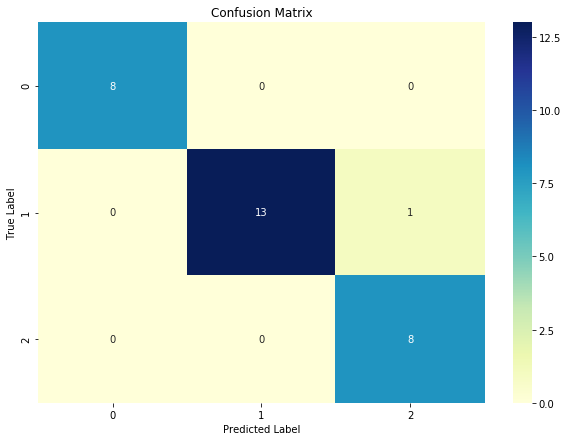

In [0]:
nn = FeedForwardModel()
nn.run(train, test)

![alt text](https://github.com/shruti-singh/DL-NLP/blob/master/images/FeedFwdNw.png?raw=1)

![alt text](https://github.com/shruti-singh/DL-NLP/blob/master/images/loss_3000.png?raw=1)

Loss on the training set converges after ~2k iterations.